# GJC Scheme with loss

This notebook implements and simulates a noisy GJC telescopy setup, with two telescopes and one resource photon.

In [1]:
import functools
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.diagram import draw
from squint.ops.fock import (
    BeamSplitter,
    FockState,
    TwoModeWeakThermalState,
)
from squint.ops.noise import ErasureChannel
from squint.utils import print_nonzero_entries

## Definition of the optical circuit
We first define the optical circuit as a `squint.Circuit` object, which contains symbolic descriptions of the states, operators, and channels in sequential/causal order. 

The star is modelled as a weak thermal source, 
$$
\rho^{\text{star}}_{s_0, s_1} = 
\begin{bmatrix}
1 - \epsilon & 0 & 0 & 0 \\
0 & \epsilon / 2 &  |g|\exp(i\varphi) & 0 \\
0 & |g|\exp(-i\varphi) & \epsilon / 2 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}
.
$$

The (fixed) ancilla resource state is a mode-entangled state,
$$
|{\rho}\rangle^{\text{ancilla}}_{a_0, a_1} = 
\frac{1}{\sqrt{2}} \left(  |{0}\rangle_{a_0}|{1}\rangle_{a_1} + |{1}\rangle_{a_0} |{0}\rangle_{a_1} \right).
$$

This ancilla state is distributed to the left and right telescope through a lossy channel, modelled as a beamsplitter with the vacuum state on remaining port,
$$
|{\rho}\rangle^{\text{loss}}_{d_0, d_1} = |{0}\rangle_{d_0} |{0}\rangle_{d_1}
$$

In [2]:
dim = 3
wires_star = ("s0", "s1")
wires_ancilla = ("a0", "a1")
wires_dump = ("d0", "d1")

circuit = Circuit(backend="mixed")

# star modes
circuit.add(
    TwoModeWeakThermalState(wires=wires_star, epsilon=1.0, g=1.0, phi=0.1), "star"
)

# ancilla modes
circuit.add(
    FockState(
        wires=wires_ancilla,
        n=[
            (1.0, tuple(1 if i == j else 0 for i in wires_ancilla))
            for j in wires_ancilla
        ],
    ),
    "ancilla",
)

# loss modes
for i, wire_dump in enumerate(wires_dump):
    circuit.add(FockState(wires=(wire_dump,), n=(0,)), f"vac{i}")

for i in range(2):
    circuit.add(
        BeamSplitter(wires=(wires_ancilla[i], wires_dump[i]), r=0.0), f"loss{i}"
    )

for i, (wire_ancilla, wire_star) in enumerate(zip(wires_ancilla, wires_star, strict=False)):
    circuit.add(BeamSplitter(wires=(wire_ancilla, wire_star)), f"u{i}")

for i, wire_dump in enumerate(wires_dump):
    circuit.add(ErasureChannel(wires=(wire_dump,)), f"ptrace{i}")

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   'star':
│   TwoModeWeakThermalState(
│     wires=('s0', 's1'),
│     g=weak_f64[],
│     phi=weak_f64[],
│     epsilon=weak_f64[]
│   ),
│   'ancilla':
│   FockState(
│     wires=('a0', 'a1'),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   'vac0':
│   FockState(wires=('d0',), n=[(1.0, (0,))]),
│   'vac1':
│   FockState(wires=('d1',), n=[(1.0, (0,))]),
│   'loss0':
│   BeamSplitter(wires=('a0', 'd0'), r=weak_f64[]),
│   'loss1':
│   BeamSplitter(wires=('a1', 'd1'), r=weak_f64[]),
│   'u0':
│   BeamSplitter(wires=('a0', 's0'), r=weak_f64[]),
│   'u1':
│   BeamSplitter(wires=('a1', 's1'), r=weak_f64[]),
│   'ptrace0':
│   ErasureChannel(wires=('d0',)),
│   'ptrace1':
│   ErasureChannel(wires=('d1',))
  },
  _backend='mixed'
)

With the circuit defined, we verify it was constructed properly (`circuit.verify()`), followed by drawing the tensor network diagram (`circuit.draw()`) and compiling the forward, gradient, and Fisher information methods `sim = circuit.compile()`. We also define the necessary `get` function, which identifies the parameters in our system for which we want to compute the Fisher information (matrix) with respect to.

In [3]:
circuit.verify()
fig = draw(circuit)
# fig.show()

Below is the corresponding tensor network diagram of the optical circuit defined above.


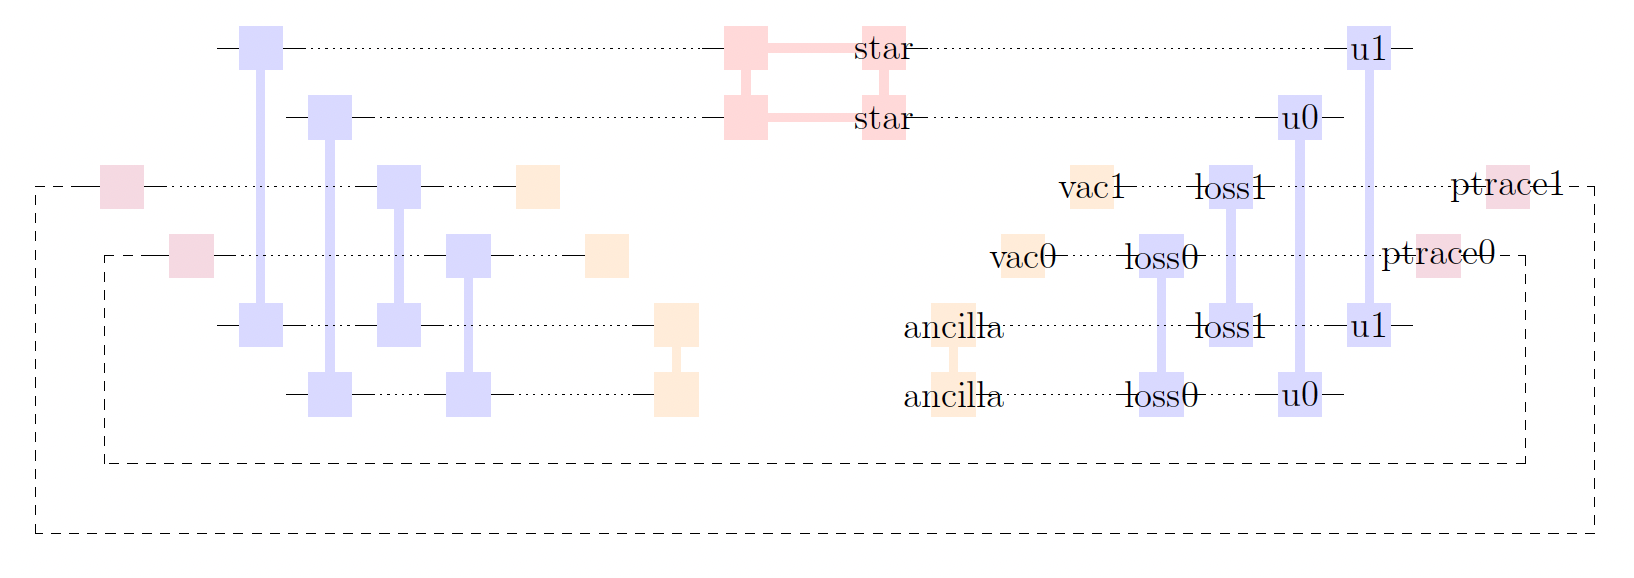

In [4]:
get = lambda pytree: jnp.array([pytree.ops["star"].phi])
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(circuit, static, dim=dim).jit()

Now, we can start simulating the optical system, e.g., the probabilities of events in the photon-number basis.  

In [5]:
print_nonzero_entries(sim.probabilities.forward(params))

Basis: [0 0 0 2], Value: 0.1249999850988388
Basis: [0 0 1 1], Value: 3.705795899477171e-33
Basis: [0 0 2 0], Value: 0.1249999850988388
Basis: [0 1 0 1], Value: 0.0006244793185032904
Basis: [0 1 1 0], Value: 0.24937547743320465
Basis: [0 2 0 0], Value: 0.1249999850988388
Basis: [1 0 0 1], Value: 0.24937547743320465
Basis: [1 0 1 0], Value: 0.0006244793185032904
Basis: [1 1 0 0], Value: 3.705795899477171e-33
Basis: [2 0 0 0], Value: 0.1249999850988388


Now, we can compute the classical Fisher information (matrix) for the parameters defined above; in this case, just $\varphi$ of the star mode.

In [6]:
cfim = sim.probabilities.cfim(get, params)
print(f"The classical Fisher information is {cfim.squeeze()}")

The classical Fisher information is 0.4999999140812005


In [7]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)


def update(phi, params):
    return eqx.tree_at(lambda pytree: pytree.ops["star"].phi, params, phi)


probs = jax.lax.map(lambda phi: sim.probabilities.forward(update(phi, params)), phis)
qfims = jax.lax.map(lambda phi: sim.amplitudes.qfim(get, update(phi, params)), phis)
cfims = jax.lax.map(lambda phi: sim.probabilities.cfim(get, update(phi, params)), phis)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, 'Probability, $p(\\mathbf{x} | \\varphi)$')]

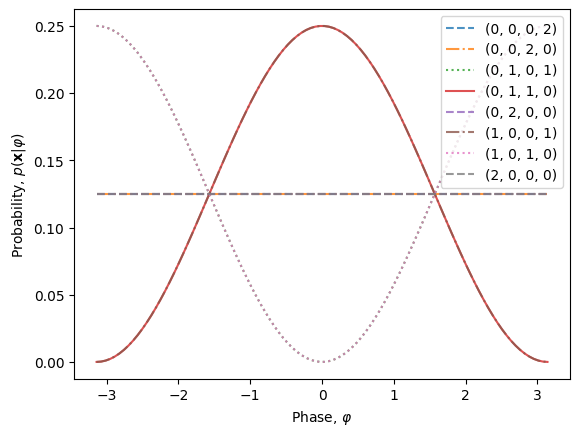

In [8]:
colors = itertools.cycle(
    sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
)
styles = itertools.cycle(["--", "-.", ":", "solid", "dashed", "dashdot", "dotted"])
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    if jnp.mean(probs[:, *idx]) < 1e-6:
        continue
    label = f"{idx}" if jnp.mean(probs[:, *idx]) > 1e-6 else None
    # print(label, jnp.mean(probs[:, *idx]))
    ax.plot(
        phis,
        probs[:, *idx],
        label=label,
        color=next(colors),
        ls=next(styles),
        alpha=0.8,
    )
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")

## Classical Fisher Information under lossy resource distribution link

First, we characterize the CFI, with respect to $\varphi$, of the output photon number probabilities under a lossy resource distribution channel.

As usual, we model the loss using a beam-splitter with reflectivity, $\eta$, sweeping from $\eta \in [0, \pi/2]$ (i.e., no loss to complete loss).

In [9]:
etas = jnp.linspace(0, jnp.pi / 2, 50)

colors = itertools.cycle(sns.color_palette("viridis", n_colors=9))
styles = itertools.cycle(["-", "-.", ":", "--"])

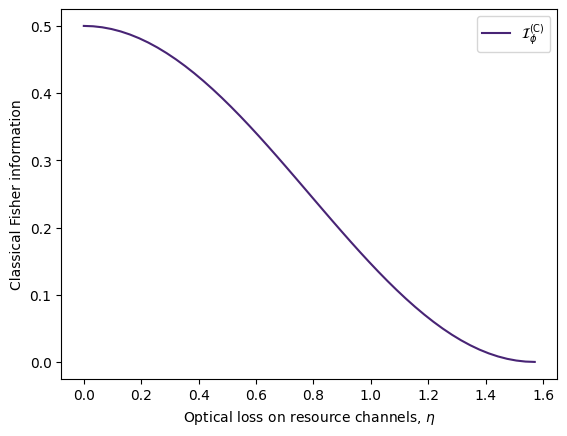

In [10]:
def update(r, params):
    # return eqx.tree_at(lambda pytree: [pytree.ops[f"loss0"].r, pytree.ops[f"loss1"].r], params, [r, r])
    return eqx.tree_at(
        lambda pytree: [pytree.ops[f"loss{i}"].r for i in range(2)],
        params,
        [r for i in range(2)],
    )


def sweep_cfim(r, get, params):
    return sim.probabilities.cfim(get, update(r, params))


cfims = jax.lax.map(functools.partial(sweep_cfim, get=get, params=params), etas)

fig, ax = plt.subplots(ncols=1)
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in cfims.shape[1:]])
):
    ax.plot(
        etas,
        cfims[:, *idx],
        label=r"$\mathcal{I}^{\text{(C)}}_{\phi}$",
        color=next(colors),
    )
ax.set(
    xlabel=r"Optical loss on resource channels, $\eta$",
    ylabel=r"Classical Fisher information",
)
ax.legend()
plt.show()

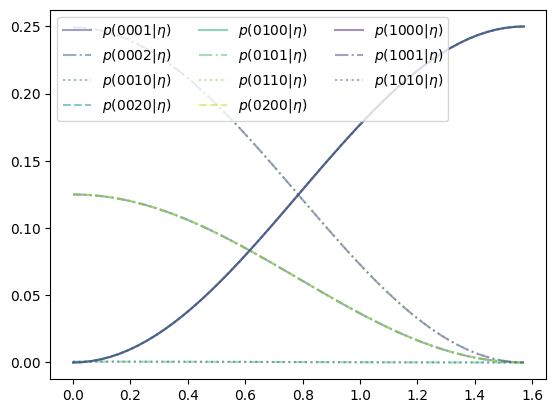

In [11]:
def sweep_prob(r, params):
    return sim.probabilities.forward(update(r, params))


probs = jax.lax.map(functools.partial(sweep_prob, params=params), etas)

fig, ax = plt.subplots(ncols=1)
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    if jnp.mean(probs[i, *idx]) < 1e-6:
        continue
    ax.plot(
        etas,
        probs[:, *idx],
        label=f"$p({''.join(map(str, idx))}" + r"| \eta )$",
        color=next(colors),
        ls=next(styles),
        alpha=0.5,
    )

ax.legend(ncols=3)
plt.show()

## Consider the Fisher information of $|g|$, i.e., multiparameter estimation



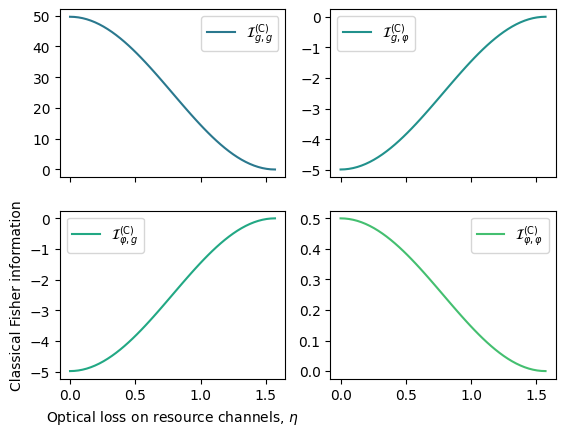

In [12]:
names = [r"g", r"\varphi"]
get = lambda pytree: jnp.array([pytree.ops["star"].g, pytree.ops["star"].phi])

cfims = jax.lax.map(functools.partial(sweep_cfim, get=get, params=params), etas)

fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=False)
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in cfims.shape[1:]])
):
    ax[*idx].plot(
        etas,
        cfims[:, *idx],
        label=r"$\mathcal{I}^{\text{(C)}}_{"
        + f"{names[idx[0]]},{names[idx[1]]}"
        + r"}$",
        color=next(colors),
    )
    ax[*idx].legend()

ax[-1, 0].set(
    xlabel=r"Optical loss on resource channels, $\eta$",
    ylabel=r"Classical Fisher information",
)
plt.show()